## Import 

In [1]:
import pandas as pd
import os
import numpy as np
import gc
import math

In [2]:
#import tarfile

In [3]:
from scipy.io import arff

In [4]:
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns

In [5]:
import numpy.random as rand

In [6]:
from sklearn.metrics import average_precision_score, make_scorer, recall_score, roc_auc_score, \
                            precision_score, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, \
                                    StratifiedKFold
from sklearn.linear_model import SGDClassifier


In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
pd.set_option('display.max_columns', 30)

## Constants

In [9]:
data_path = 'Data/'
plot_path = 'Plots/'

## Functions

### Visualization

In [10]:
## plot the heatmap that shows the correlation coef value
## corr - correlation matrix

def plot_corr(corr):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
# scatter plot for x and y from df
# adds median, q(0.25) - 1.5 IQR, and q(0.75) + 1.5 IQR for each variable

def scatter_plot(df, x, y):
    plt.scatter(df.loc[:, x], df.loc[:, y], c="c", alpha=0.3)
    plt.xlabel(x)
    plt.ylabel(y)
    
    # add quantiles of x
    t = plt.yticks()[0]
    l = len(t)
    q = df.loc[:, x].quantile([0.25, 0.5, 0.75])
    delta = q.iloc[2] - q.iloc[0]
    plt.plot([q.iloc[1]] * l, t, c='r', label='x median')
    plt.plot([q.iloc[0] - 1.5 * delta] * l, t, c='r', dashes=[4, 2], label='x low border')
    plt.plot([q.iloc[2] + 1.5 * delta] * l, t, c='r', dashes=[4, 2], label='x high border')
    
    # add quantiles of y
    t = plt.xticks()[0]
    l = len(t)
    q = df.loc[:, y].quantile([0.25, 0.5, 0.75])
    delta = q.iloc[2] - q.iloc[0]
    plt.plot(t, [q.iloc[1]] * l, c='m', label='y median')
    plt.plot(t, [q.iloc[0] - 1.5 * delta] * l, c='m', dashes=[4, 2], label='y low border')
    plt.plot(t, [q.iloc[2] + 1.5 * delta] * l, c='m', dashes=[4, 2], label='y high border')
    
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

In [12]:
## plot two histograms side by side: one for raw data, one for transformed
## and save to .pdf

def plot_hist(data_raw, data_transformed, add):
    n = data_raw.shape[0]
    b = int(n**(0.5))
    c1 = sns.cubehelix_palette(8)[2]
    c2 = sns.cubehelix_palette(8)[5]
    
    pdf = matplotlib.backends.backend_pdf.PdfPages(plot_path + 'hist_' + add + '.pdf')

    for var in data_raw.columns.values:
        fig = plt.figure()
        # first plot
        plt.subplot(211)
        plt.hist(data_raw.loc[:, var], bins=b, density=True, alpha=0.6, color=c1)
        title = var + ' raw data'
        plt.title(title)
        # second plot
        plt.subplot(212)
        plt.hist(data_transformed.loc[:, var], bins=b, density=True, alpha=0.6, color=c2)
        title = var + add+ '-transformed data'
        plt.title(title)
        # save it
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches = 'tight')
        plt.close()
        
    pdf.close()

In [13]:
def plot_boxplts(data_raw, data_transformed, add):
    
    pdf = matplotlib.backends.backend_pdf.PdfPages(plot_path + 'boxplot_' + add + '.pdf')
    c1 = sns.cubehelix_palette(8)[2]
    c2 = sns.cubehelix_palette(8)[5]

    for var in data_raw.columns.values:
        #fig = plt.figure()
        fig, axes = plt.subplots(1, 2)
        # first plot
        #plt.subplot(211)
        sns.boxplot(data_raw.loc[:, var], color = c1, ax=axes[0])
        #data_raw.boxplot(column=[var], color = c1)
        axes[0].set_title(var + ' (raw)')
        # second plot
        #plt.subplot(212)
        sns.boxplot(data_transformed.loc[:, var], color = c2, ax=axes[1])
        #data_transformed.boxplot(column=[var], color = c2)
        axes[1].set_title(var + ' (' + add + ')')
        # save it
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches = 'tight')
        plt.close()
    
    pdf.close()

### Models

In [83]:
def find_optimal_SGD(train, target, params, random=True, score='roc_auc', refit=True, 
                     n=3, n_it=10, max_iter=100, best_only=True):
    
    sgd = SGDClassifier(penalty='elasticnet',
                     shuffle=True,
                     learning_rate='optimal',
                     max_iter=max_iter)    
    
    if random:
        sc = RandomizedSearchCV(
            estimator=sgd,
            param_distributions=params[0],
            scoring=score,
            refit = refit,
            cv=StratifiedKFold(n_splits=n, shuffle=True, random_state=42),
            verbose=1,
            n_iter = n_it
        )
    else:
        sc = GridSearchCV(
            estimator=sgd,
            param_grid=params[0], 
            scoring=score,
            refit = refit,
            verbose=1,
            cv=StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
        )
    
    sc_fit = sc.fit(train, target)   
    classifier = sc.best_estimator_
    
    y = classifier.predict(train)
    
    if classifier.loss_function_ == 'log':
        y_p = classifier.predict_proba(train)   
    else:
        y_p = y
    
    classification_report(target, y, y_p)
    
    if best_only:
        return classifier, sc.cv_results_
    else:
        return sc

In [15]:
def classification_report(target, y, y_p, disp=True):
    p, r, _ = precision_recall_curve(target, y_p)
    
    if disp:
        print('PR AUC: %.2f' %auc(r, p))
        print('Recall score: %.2f' %recall_score(target, y))
        print('Precision score: %.2f' %precision_score(target, y))
        print('ROC AUC: %.2f' %roc_auc_score(target, y_p))
        print('Avg precision: %.2f' %average_precision_score(target, y_p))
    else:
        return auc(r, p), recall_score(target, y), \
                precision_score(target, y), roc_auc_score(target, y_p),\
                average_precision_score(target, y_p)
    

### Load and save data

In [33]:
# save and load data 

def save_dataset(X_train, X_test, y_train, y_test, add=''):
    X_train.to_csv( data_path + 'X_train' + add + '.data' )
    X_test.to_csv( data_path + 'X_test' + add + '.data' )
    y_train.to_csv( data_path + 'y_train' + add + '.data' )
    y_test.to_csv( data_path + 'y_test' + add + '.data' )
    

def load_dataset(add=''):
    X_train = pd.read_csv( data_path + 'X_train' + add + '.data' , index_col=0)
    X_test = pd.read_csv( data_path + 'X_test' + add + '.data' , index_col=0)
    y_train = pd.read_csv( data_path + 'y_train' + add + '.data' , index_col=0)
    y_test = pd.read_csv( data_path + 'y_test' + add + '.data' , index_col=0)
    
    return X_train, X_test, y_train, y_test

### Other

In [17]:
def pr_auc(true, pred_prob):
    p, r, _ = precision_recall_curve(true, pred_prob)
    return auc(r, p)

## Preprocessing

#### 1. Read data

In [18]:
#os.listdir(data_path)

In [19]:
#tar = tarfile.open(data_path + os.listdir(data_path)[0])
#tar.extractall(data_path)
#tar.close()

In [21]:
data = arff.loadarff(data_path + 'ALOI/' + 'ALOI.arff')
df = pd.DataFrame(data[0])

#### 2. First look

The first column is the indicator if the observation is outlier, but in the string format, so I'll change it to int.

The last column is a unique id of the observation, so I use it like the index.

Other 27 variables are float ones.

In [21]:
df.head()

outlier      att1      att2  att3      att4  att5  att6  att7  att8  att9  \
0  b"'yes'"  0.872812  0.000005   0.0  0.000036   0.0   0.0   0.0   0.0   0.0   
1  b"'yes'"  0.975206  0.000000   0.0  0.000651   0.0   0.0   0.0   0.0   0.0   
2  b"'yes'"  0.963777  0.000000   0.0  0.002005   0.0   0.0   0.0   0.0   0.0   
3  b"'yes'"  0.973246  0.000000   0.0  0.000556   0.0   0.0   0.0   0.0   0.0   
4  b"'yes'"  0.960720  0.000000   0.0  0.000656   0.0   0.0   0.0   0.0   0.0   

      att10     att11  att12     att13     att14  att15     att16     att17  \
0  0.050327  0.000005    0.0  0.005631  0.004164    0.0  0.000002  0.000020   
1  0.007039  0.000000    0.0  0.009996  0.000470    0.0  0.000000  0.000000   
2  0.006642  0.000002    0.0  0.012352  0.000671    0.0  0.000000  0.000007   
3  0.008979  0.000002    0.0  0.012433  0.000215    0.0  0.000000  0.000000   
4  0.013319  0.000000    0.0  0.013891  0.000206    0.0  0.000000  0.000000   

   att18     att19     att20  att21     att22     att23     att24     att25  \
0    0.0  0.014212  0.000104    0.0  0.025490  0.004937  0.000011  0.000054   
1    0.0  0.000000  0.000000    0.0  0.004853  0.001582  0.000000  0.000000   
2    0.0  0.000000  0.000000    0.0  0.007828  0.002523  0.000000  0.000393   
3    0.0  0.000000  0.000000    0.0  0.004392  0.000170  0.000000  0.000000   
4    0.0  0.000000  0.000000    0.0  0.010299  0.000561  0.000000  0.000084   

      att26     att27   id  
0  0.006804  0.015385  1.0  
1  0.000201  0.000000  2.0  
2  0.003800  0.000000  3.0  
3  0.000007  0.000000  4.0  
4  0.000264  0.000000  5.0

In [22]:
df.loc[:, 'id'] = df.loc[:, 'id'].astype('int64', copy=False)
df.set_index('id', inplace=True)

In [22]:
df.outlier.unique()

array([b"'yes'", b"'no'"], dtype=object)

In [23]:
# code categorical column
# 1 - oulier
# 0 - normal
df.loc[:, 'outlier'] = df.loc[:, 'outlier'].astype('category')
df.loc[:, 'outlier'] = df.loc[:, 'outlier'].cat.codes

In [24]:
df.shape

(50000, 28)

#### 3. Descriptive statistics

1. Data contain no na
2. In the underneath table data sorted in such a way that first columns are the most suspicious on the outliers as the they have large variation and deviation of mad from std.
3. Almost all features have values around the 0, except attr1.
4. Most of them have long right tail (except attr 1, that have long legt tail).

In [26]:
stat = df.describe()

# add extra statistics

stat.loc['max - 75%'] = (df.max() - df.quantile([0.75])).values[0]  
stat.loc['25% - min'] = (df.quantile([0.25]) - df.min()).values[0]

stat.loc['median'] = stat.loc['50%']
stat.loc['mad'] = df.mad()
stat.loc['mad_std %'] =  abs(stat.loc['mad'] - stat.loc['std'])*100 / stat.loc['mad']  # how differ MAD and std in %
stat.loc['med_mean'] = abs(stat.loc['median'] - stat.loc['mean']) # how differ mean and median 
stat.loc['CV %'] = stat.loc['std'] * 100 / stat.loc['mean']
stat.loc['na'] = df.isna().sum()                           
                             

In [27]:
# make convinient order of rows

stat.drop(index='50%', inplace=True)
stat = stat.reindex(['count', 'na', 'mean', 'median', 'med_mean',
                 'std', 'mad',  'mad_std %', 'CV %',
                 'min', '25%', '75%', 'max',
                 'max - 75%', '25% - min'])

In [28]:
stat.iloc[:, 1:].sort_values(by=['CV %', 'mad_std %'], axis=1, ascending=False)

att21          att7         att12          att3  \
count      50000.000000  50000.000000  50000.000000  50000.000000   
na             0.000000      0.000000      0.000000      0.000000   
mean           0.000002      0.000028      0.000007      0.000162   
median         0.000000      0.000000      0.000000      0.000000   
med_mean       0.000002      0.000028      0.000007      0.000162   
std            0.000104      0.000781      0.000095      0.002093   
mad            0.000004      0.000054      0.000012      0.000310   
mad_std %   2482.554722   1341.740932    673.701197    575.599469   
CV %        4841.360384   2775.118014   1427.866368   1293.011531   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.000000      0.000000      0.000000   
75%            0.000000      0.000000      0.000000      0.000000   
max            0.011022      0.154695      0.006479      0.085418   
max - 75%      0.011022      0.154695      0.006479      0.085418   
25% - min      0.000000      0.000000      0.000000      0.000000   

                   att9          att8         att20         att16  \
count      50000.000000  50000.000000  50000.000000  50000.000000   
na             0.000000      0.000000      0.000000      0.000000   
mean           0.000125      0.000044      0.000142      0.000496   
median         0.000000      0.000000      0.000000      0.000000   
med_mean       0.000125      0.000044      0.000142      0.000496   
std            0.001526      0.000521      0.001507      0.004881   
mad            0.000242      0.000085      0.000241      0.000912   
mad_std %    531.412598    515.034822    524.535557    435.116613   
CV %        1220.186060   1171.265994   1064.483208    984.409389   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.000000      0.000000      0.000000   
75%            0.000000      0.000000      0.000014      0.000009   
max            0.057825      0.027271      0.087454      0.179143   
max - 75%      0.057825      0.027271      0.087441      0.179134   
25% - min      0.000000      0.000000      0.000000      0.000000   

                  att11          att6         att15         att24  \
count      50000.000000  50000.000000  50000.000000  50000.000000   
na             0.000000      0.000000      0.000000      0.000000   
mean           0.000444      0.000455      0.000653      0.000130   
median         0.000032      0.000000      0.000002      0.000011   
med_mean       0.000413      0.000455      0.000651      0.000119   
std            0.003156      0.003146      0.004133      0.000791   
mad            0.000666      0.000832      0.001073      0.000181   
mad_std %    373.594566    278.275200    285.134822    338.216165   
CV %         710.174784    690.630576    632.736658    608.110880   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.000000      0.000000      0.000000   
75%            0.000165      0.000000      0.000104      0.000075   
max            0.145408      0.105959      0.104054      0.056392   
max - 75%      0.145243      0.105959      0.103950      0.056317   
25% - min      0.000000      0.000000      0.000000      0.000000   

                  att17         att18          att4          att2  \
count      50000.000000  50000.000000  50000.000000  50000.000000   
na             0.000000      0.000000      0.000000      0.000000   
mean           0.000557      0.000810      0.002165      0.002935   
median         0.000045      0.000002      0.000151      0.000020   
med_mean       0.000511      0.000808      0.002013      0.002915   
std            0.003014      0.004306      0.010481      0.012711   
mad            0.000792      0.001369      0.003183      0.004693   
mad_std %    280.570717    214.455851    229.301702    170.841623   
CV %         541.429756    531.471648    484.177906    433.068587   
min          

#### 4. Correlations

Mainly features have low and moderate Pearson's correlation coefficient.

Attr1 have with all features negative correlation.

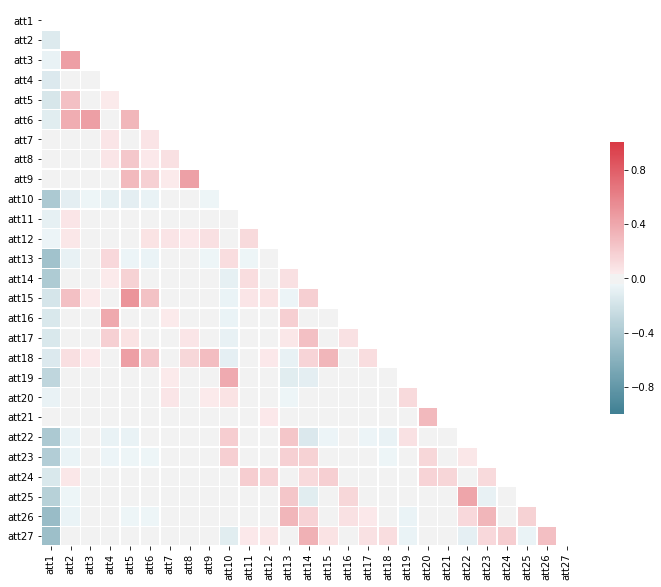

In [29]:
# Pearson correlation plot
cor_p = df.iloc[:, 1:].corr('pearson')
plot_corr(cor_p)

Many features have high positive Spearman's correlation coefficient.

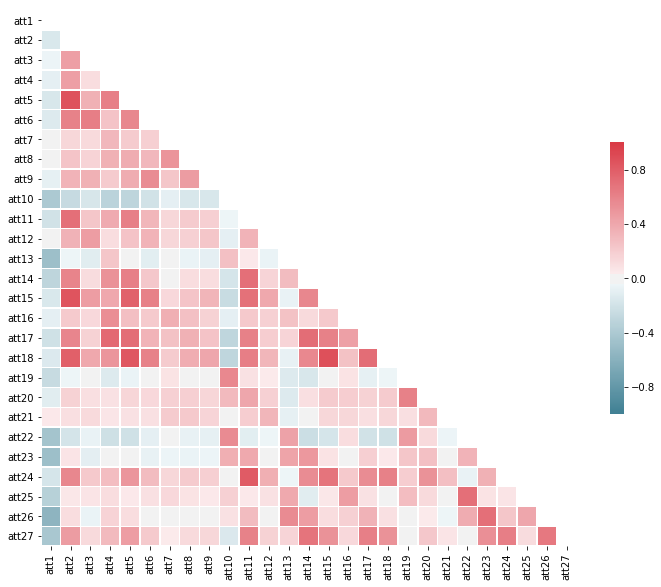

In [30]:
# Spearman correlation plot
cor_s = df.iloc[:, 1:].corr('spearman')
plot_corr(cor_s)

In [31]:
# find the most correlated pairs
# to make better visualization for them
cor_p = cor_p.abs()
cor_p = cor_p.unstack()
rem = [(i,i) for i in df.columns.values[1:]]
cor_p.drop(rem, inplace=True)

For the most correlated pairs scatter plot is drawn.

Everything ouside the dashed lines considered as outlier accordingly to Tukey's rule

There are 11 scatter plots of pairs with absolute Pearson's correlation greater than 0.4 and 30 of pairs that have absolute Spearman's correlation greater than 0.6. All of plots show than there a lot ob observations that could be considered as ouliers according to Tukey's borders. I think that it could be due to the fact that all variables are naturally assymetric and have long tails. May be it is better firstly trasform then to reduce assymetry, and then to search for outliers.

But even now I think that several pairs look suspicious:

* have dense spots pretty far from Tukey's  borders and they are not uniform:
    * att22 and att25 
    * att19 and att20
    * att9 and att8
    * att 15 and att6
    * att5 and att2
* have some pattern in possible outliers:
    * att5 and att15 
    * att15 and att18
    * att15 and att2
    * att17 and att4

In [32]:
# add all pairs of variables that have correlation higher than 0.4
# cor_p contains symmetrical pairs only every second one is appended

indx_p = {pair for k, pair in enumerate(zip(cor_p[cor_p > 0.4].index.get_level_values(0).values,
                                          cor_p[cor_p > 0.4].index.get_level_values(1).values))
                                           if (k % 2) == 0}


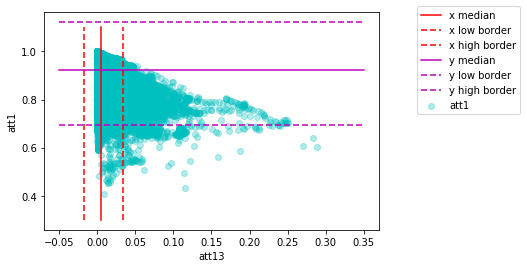

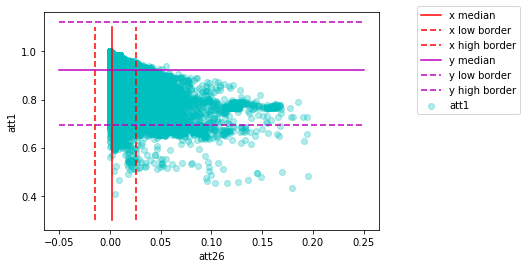

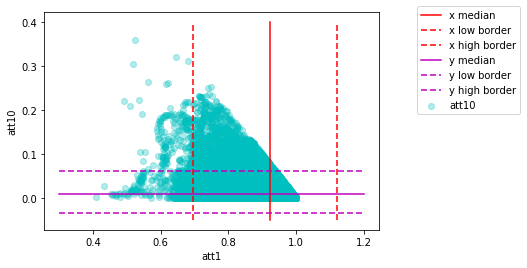

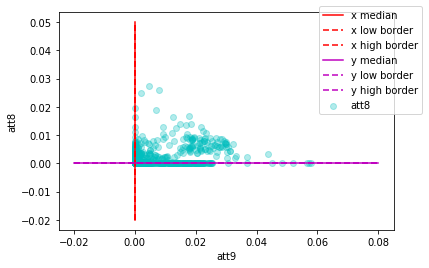

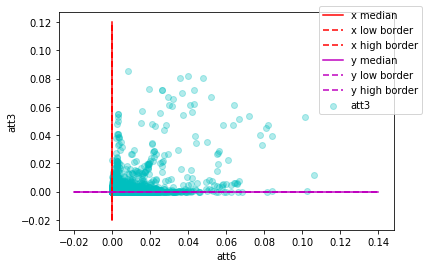

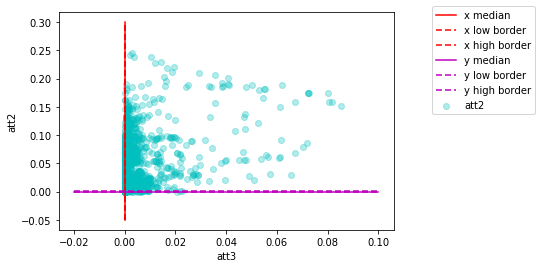

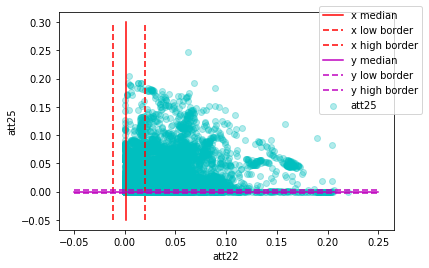

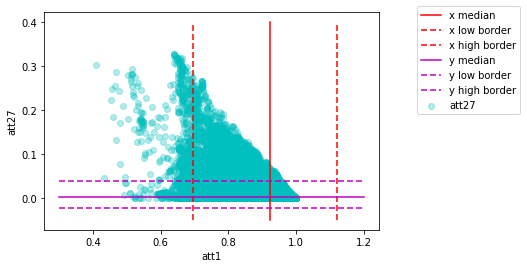

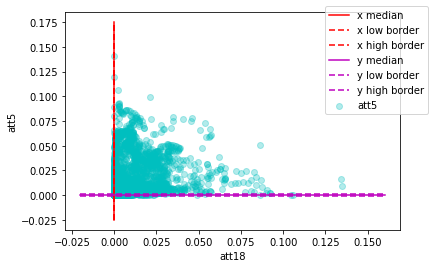

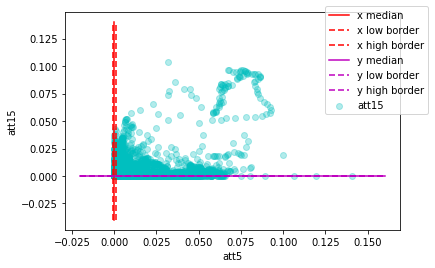

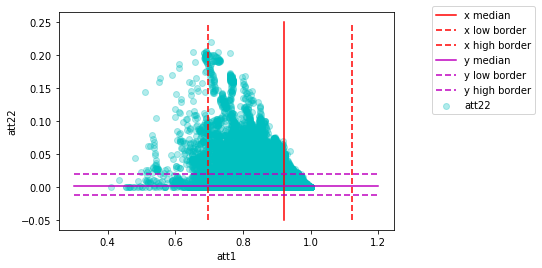

In [33]:
for i in indx_p:
    scatter_plot(df, i[0], i[1])

In [34]:
# all the same for Spearman's cor
cor_s = cor_s.abs()
cor_s = cor_s.unstack()
cor_s.drop(rem, inplace=True)

In [35]:
# add all variables that have with any other variable correlation higher than 0.6
indx_s = {pair for k, pair in enumerate(zip(cor_s[cor_s > 0.6].index.get_level_values(0).values,
                                          cor_s[cor_s > 0.6].index.get_level_values(1).values))
                                           if (k % 2) == 0}
indx_s = {i for i in indx_s if i not in indx_p}

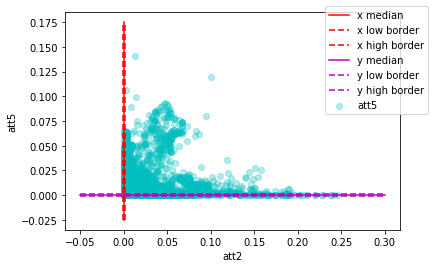

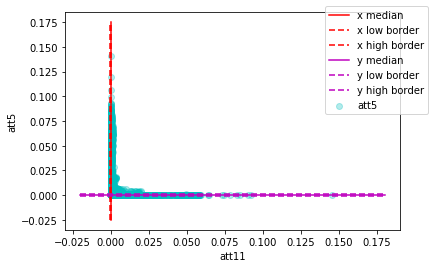

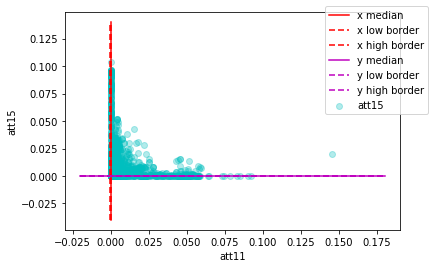

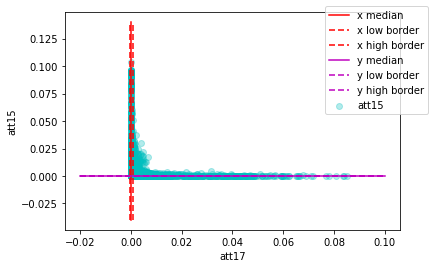

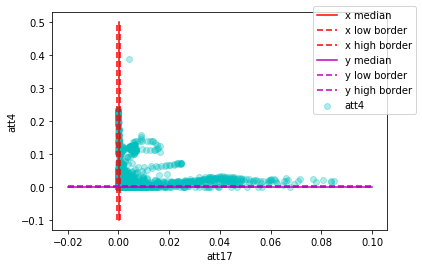

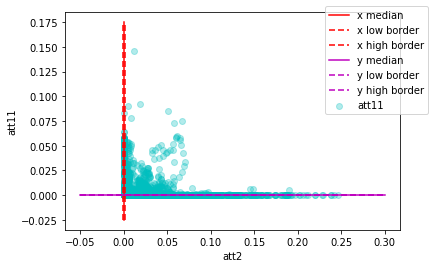

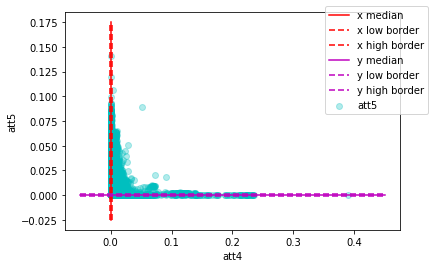

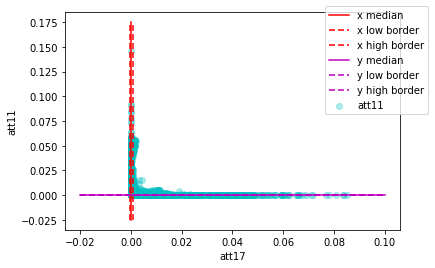

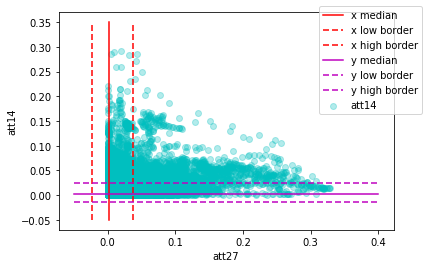

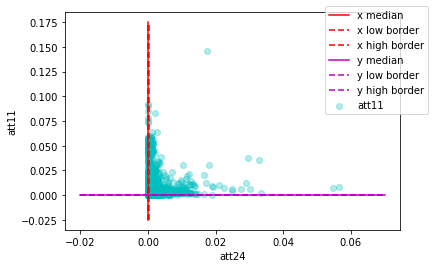

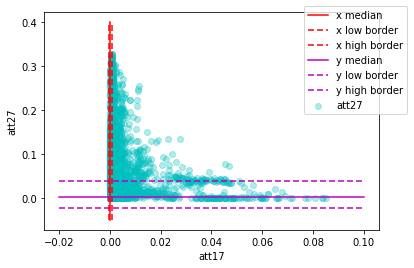

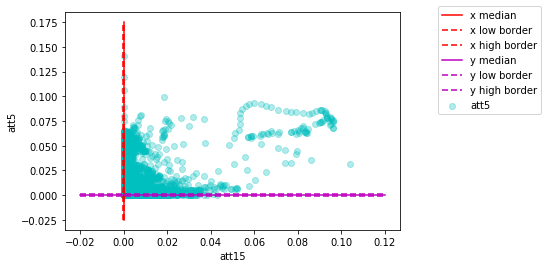

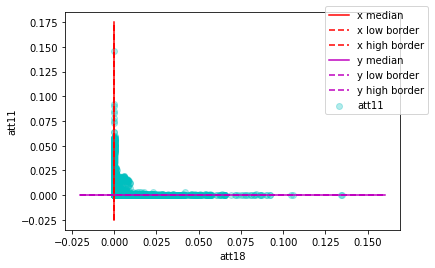

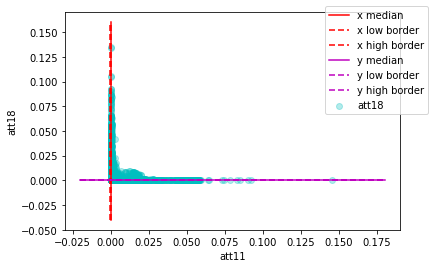

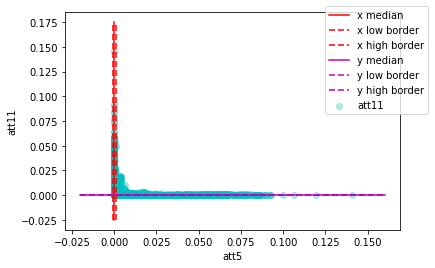

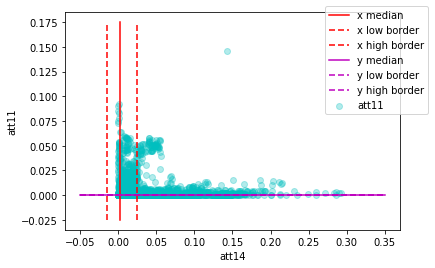

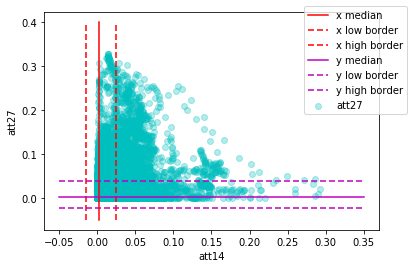

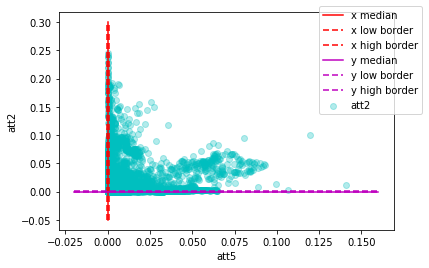

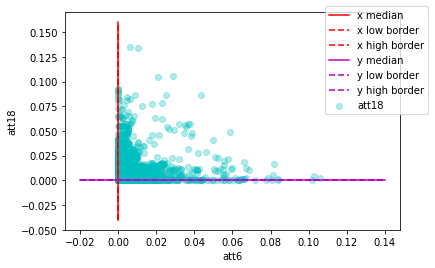

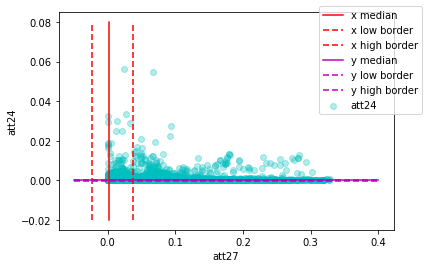

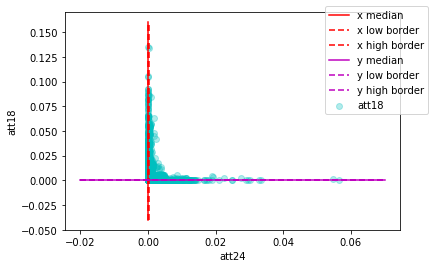

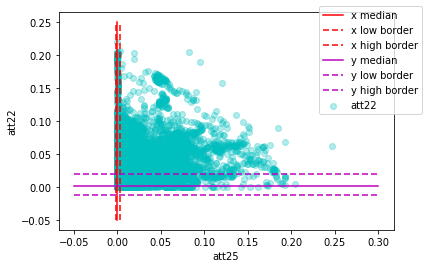

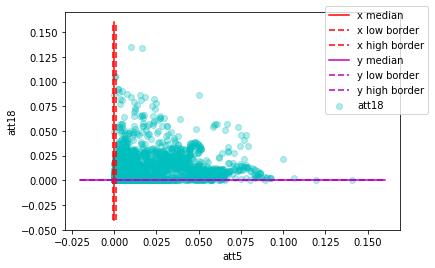

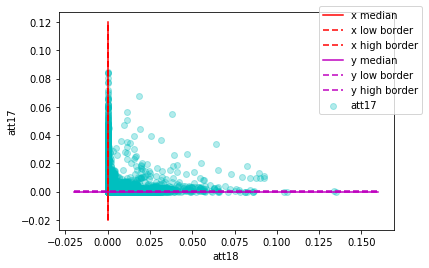

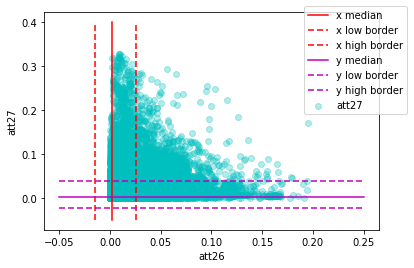

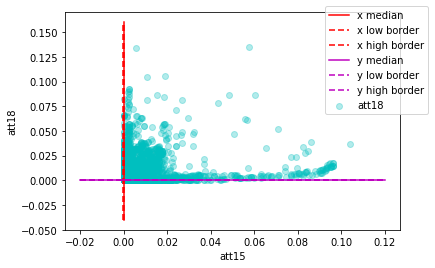

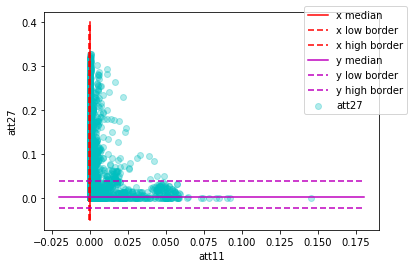

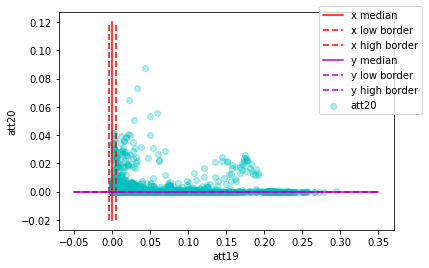

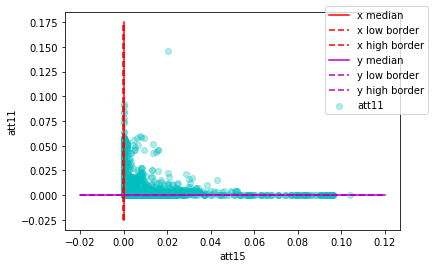

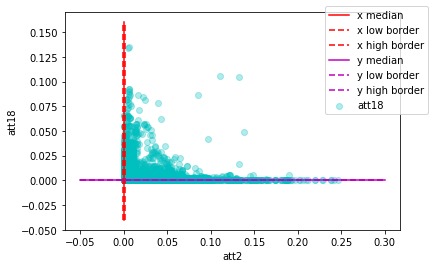

In [36]:
for i in indx_s:
    scatter_plot(df, i[0], i[1])

In [37]:
del cor_s, cor_p, rem

In [24]:
# make log transformation 
# small positive constant is neccessary as there are 0 values in the dataset
df_log = df.apply(lambda x: x.apply(lambda y: math.log(y + 0.1**(10)) ))

There are plots of log transformed data underneath. Almost in all plots the separate line (or more separate lines) is presented. Mainly these are lines when one of coordinates is about -23 so this corresponds to 0 in raw data. It is strange that zeros are so far away from other observatins that look more scattered. Now just a few pairs have observations outside the dashed box, so a fewer amount of dots are suspicious. 

Futher I'm going to plot histograms and boxplots for each variable separetly.

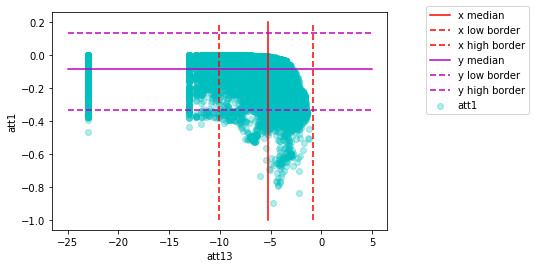

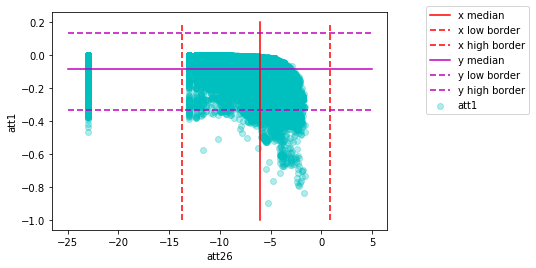

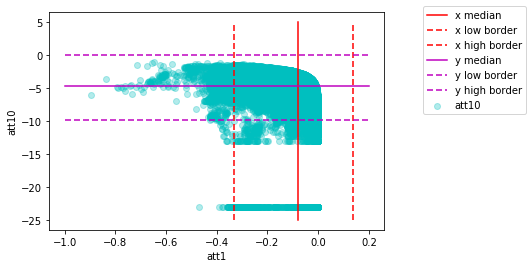

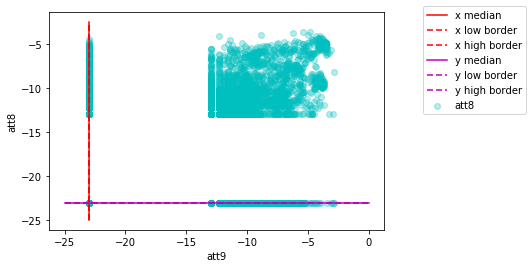

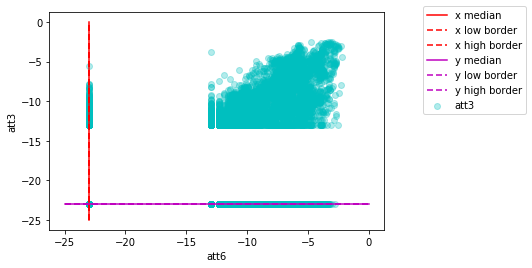

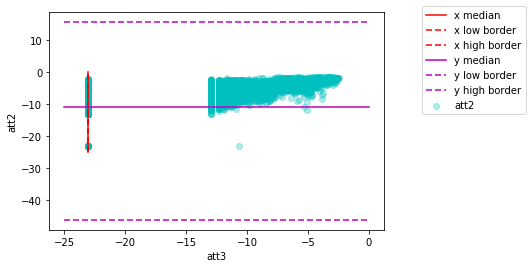

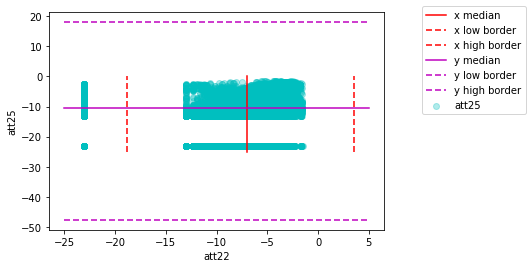

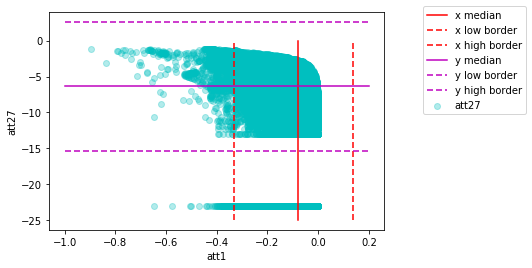

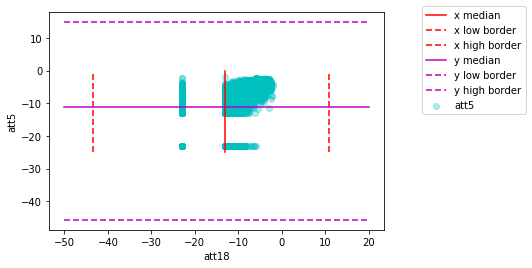

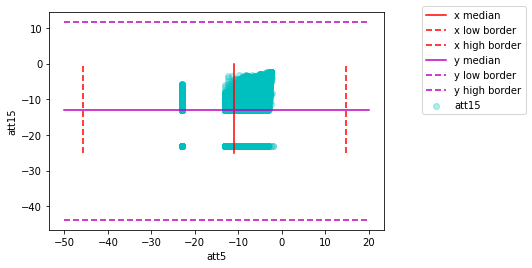

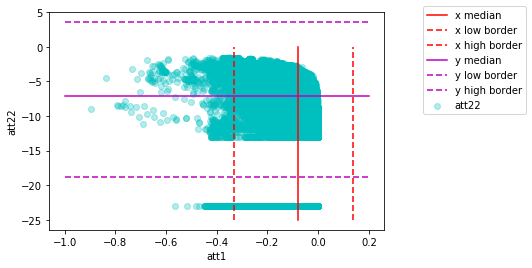

In [39]:
for i in indx_p:
    scatter_plot(df_log, i[0], i[1])

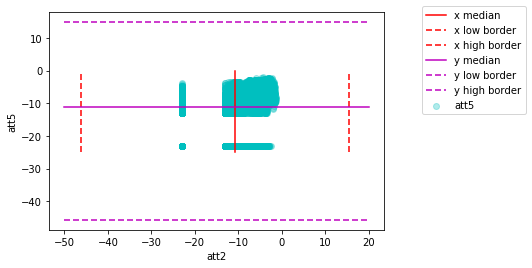

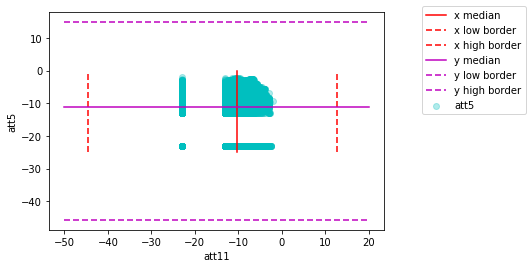

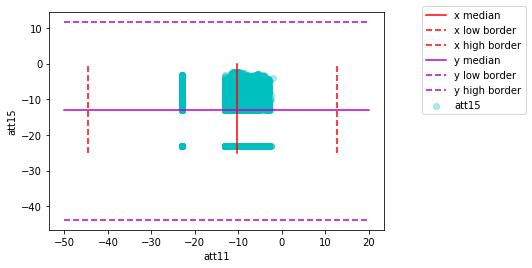

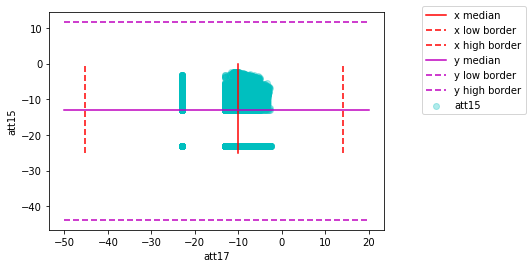

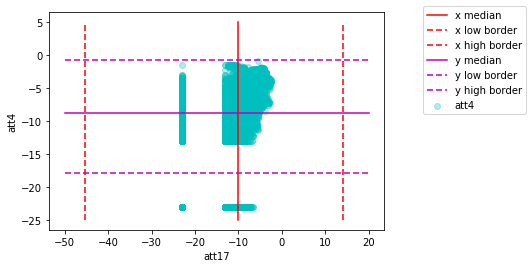

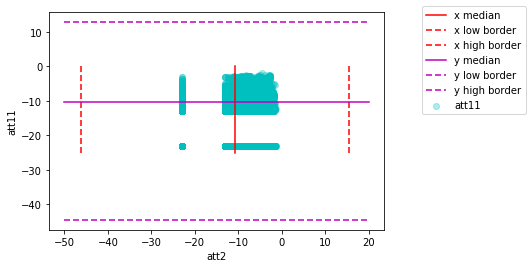

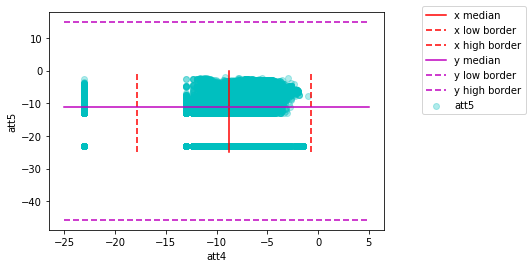

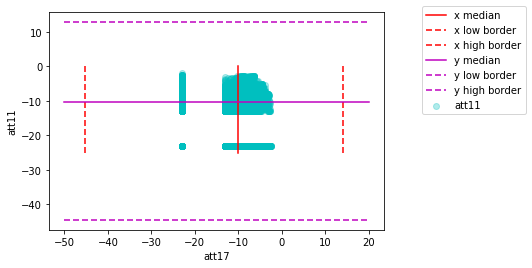

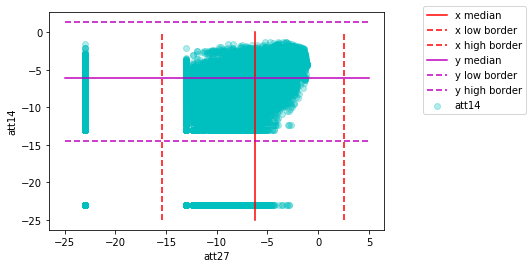

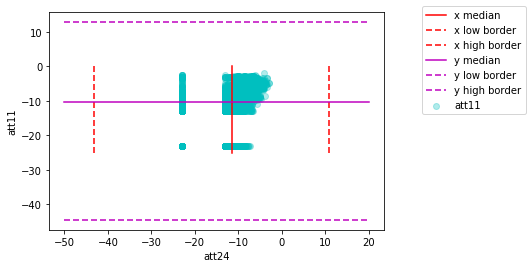

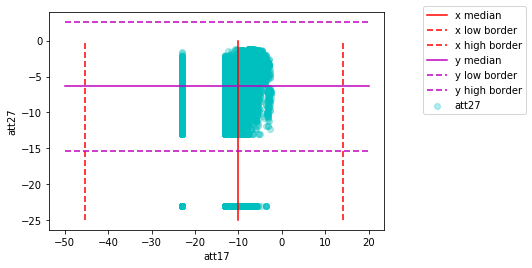

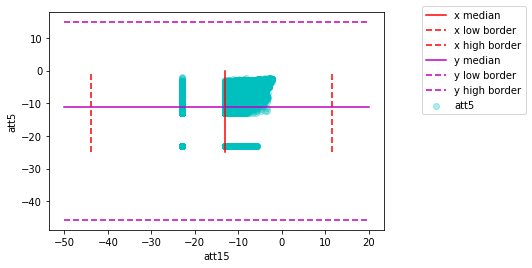

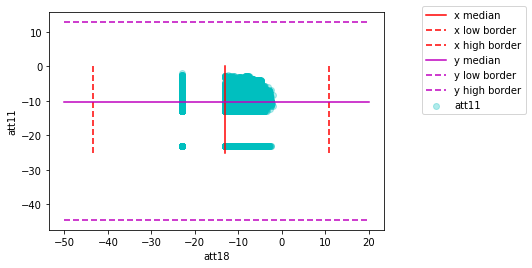

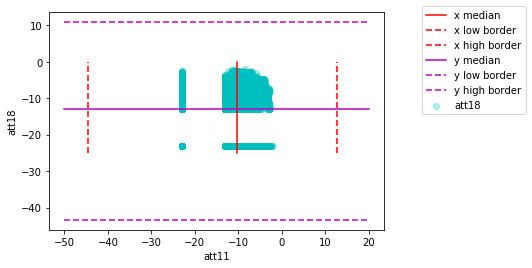

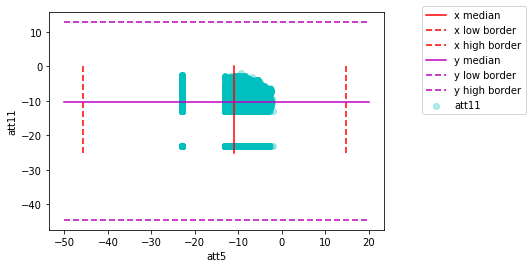

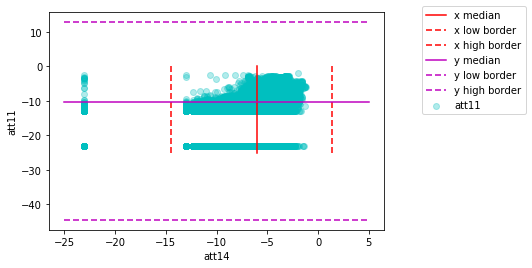

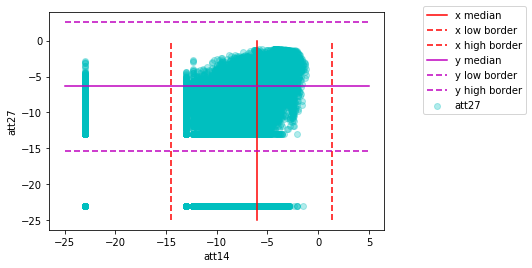

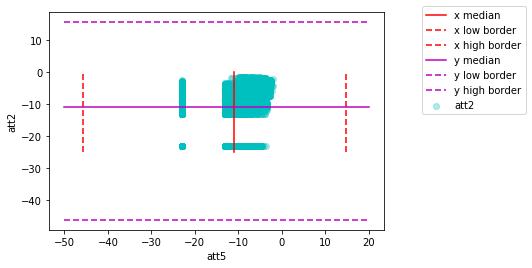

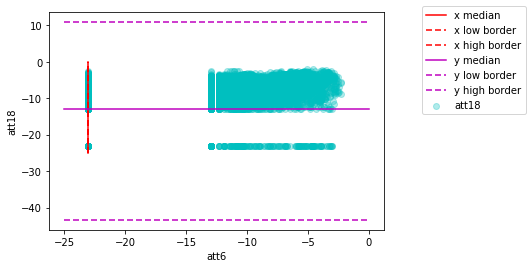

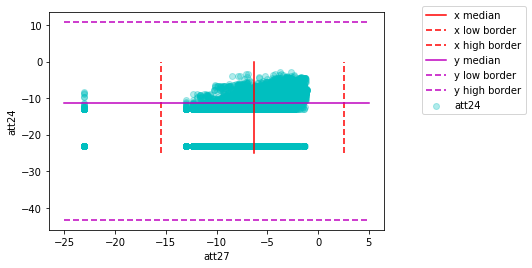

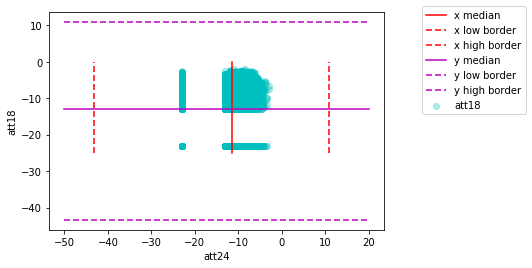

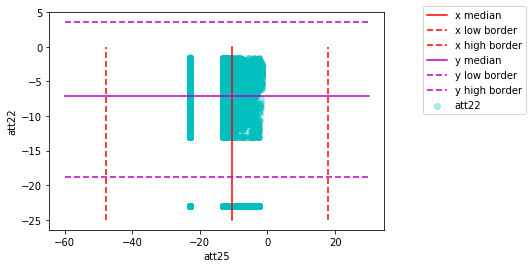

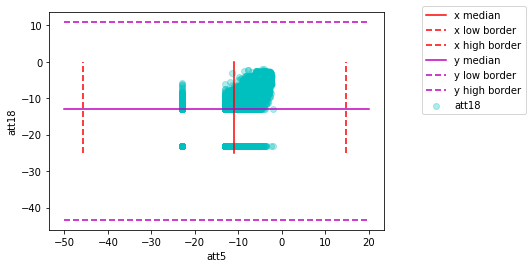

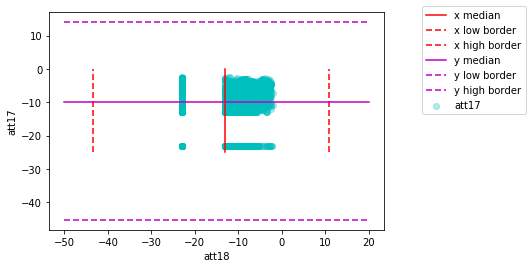

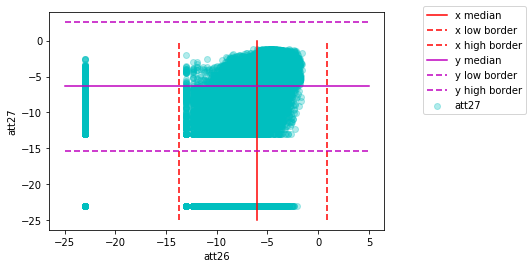

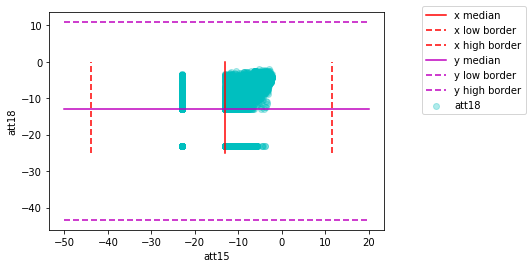

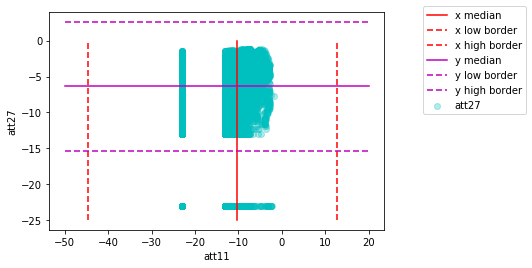

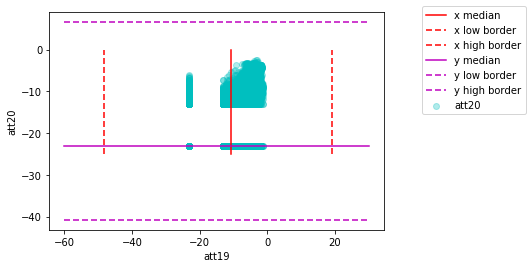

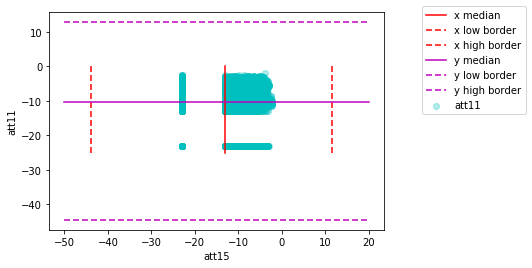

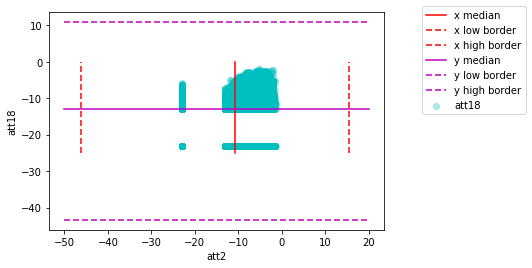

In [40]:
for i in indx_s:
    scatter_plot(df_log, i[0], i[1])

**Study the plots: histogram and boxplot**

I've tried two transformations here that could be appropriate for assymetric distributions: logarithmic amd pow, both of them give very similar result, so I'll use only logarithmic futher.

Transformation reveals that for most variables zero and positive values are quite separate (distribution do not look continuous because of the gap between the values). But for some of features zero-values are more coommon while for other - positive values. Therefore in boxplots it could be seen that somewhere values around -23 (0-values) considered as outlier while somewhere all dots except -23 (zero-values) are considered as outliers. I wonder what is the reason and is that real outliers? Anyway, futher it is better to use both raw and log-transformed data, as according t boxplots of raw data too much dots are outliers but this is just due to assymetry of distribution. 

In [41]:
plot_hist(df.iloc[:, 1:], df_log.iloc[:, 1:], 'log')

In [26]:
# another transformation that may suit here
# as it does differences among small values bigger
df_pow = df.apply(lambda x: x.apply(lambda y: y**(0.1) ))

In [43]:
plot_hist(df.iloc[:, 1:], df_pow.iloc[:, 1:], 'pow')

In [44]:
plot_boxplts(df.iloc[:, 1:], df_log.iloc[:, 1:], 'log')

As att1 has different distribution log-transformation does almost nothing with the data (it is obvious from histogram and boxplot), so the better choice is power transformation:

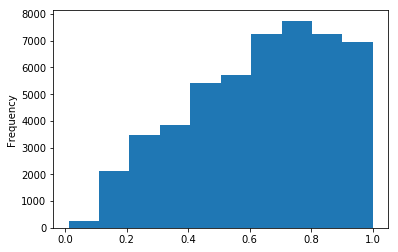

In [45]:
df.iloc[:, 1].apply(lambda x:x**5).plot.hist();

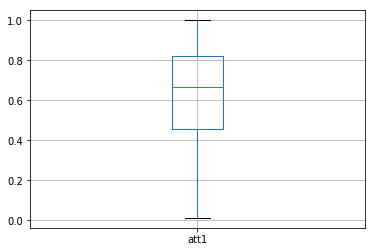

In [46]:
pd.DataFrame(df.iloc[:, 1].apply(lambda x:x**5)).boxplot();

In [25]:
# final transformed data for future analysis
df_tr = df.copy(deep=True)
df_tr.iloc[:, 2:] = df_log.iloc[:, 2:]
df_tr.iloc[:, 1] = df.iloc[:, 1].apply(lambda x:x**5)

# Supervised algorithms

The supervised outlier detection problem may be considered
a very difficult special case (or variation) of the classification problem: 
* Classification with class imbalance
* Classification of labeled data with contaminated normal class examples
* Partial training information (Semi-supervision or novel class detection)

So classification methods
need to be modified in order to address the challenges of supervised
outlier analysis. 

Imbalanced class distributions could easily lead to training algorithms which show differentially overfitting behavior. In other words, the algorithm may behave robustly for the normal class, but may overfit the rare class. Therefore, it is important to design the training algorithms, so that overfitting is avoided.

Ways to deal with imbalanced class problem:

* Cost Sensitive Learning: The objective function of the classification algorithm is modified in order to weight the errors in classification differently for different classes. Classes with greater rarity have higher costs. 

* Adaptive Re-sampling: The data is re-sampled so as to magnify the relative proportion of the rare classes. Such an approach can be considered an indirect form of cost-sensitive learning, since data re-sampling is equivalent to implicitly assuming higher costs for misclassification of rare classes.

In [39]:
# split on test and train 
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:].join(df_tr.iloc[:, 1:], on='id', rsuffix='_tr'), 
                                                    df.iloc[:, 0], test_size=0.2, shuffle = True, 
                                                    stratify = df.iloc[:, 0], random_state=42)

In [40]:
# save it to file
save_dataset(X_train, X_test, y_train, y_test)
#X_train, X_test, y_train, y_test = load_dataset()

In [26]:
df_tr.to_csv('df_transformed.data')
df.to_csv('df.data')

In [41]:
# look on frequencies of classes
pd.DataFrame({'train': y_train.groupby(y_train.values).size(),
              'test': y_test.groupby(y_test.values).size()})

train  test
0  38794  9698
1   1206   302

## Logistic regression

#### 1. Randomized Search. Include raw and transformed features

In [30]:
# set small class weight for 0 class
class_w = rand.uniform(low=0.001, high=0.2, size=20)
c = np.random.rand(100)
classifier = ['log']

params = {'class_weight': [{0: z, 1: 1.0-z} for z in class_w], 
          'l1_ratio': c,
          'loss': classifier},


model, _ = find_optimal_SGD(X_train, y_train, params, score=make_scorer(pr_auc), n_it=20)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.0min finished


PR AUC: 0.28
Recall score: 0.51
Precision score: 0.04
ROC AUC: 0.57


In [31]:
# all raw features have zero coefficient
# so futher only transformed variant of features is used
model_coef = pd.DataFrame({'features': X_train.columns.values, 'logit coef': model.coef_[0]}) 
model_coef

features  logit coef
0       att1    0.000000
1       att2    0.000000
2       att3    0.000000
3       att4    0.000000
4       att5    0.000000
5       att6    0.000000
6       att7    0.000000
7       att8    0.000000
8       att9    0.000000
9      att10    0.000000
10     att11    0.000000
11     att12    0.000000
12     att13    0.000000
13     att14    0.000000
14     att15    0.000000
15     att16    0.000000
16     att17    0.000000
17     att18    0.000000
18     att19    0.000000
19     att20    0.000000
20     att21    0.000000
21     att22    0.000000
22     att23    0.000000
23     att24    0.000000
24     att25    0.000000
25     att26    0.000000
26     att27    0.000000
27   att1_tr   -2.636515
28   att2_tr    0.000000
29   att3_tr    0.032299
30   att4_tr    0.046936
31   att5_tr    0.044964
32   att6_tr    0.000000
33   att7_tr    0.088989
34   att8_tr    0.101448
35   att9_tr    0.064315
36  att10_tr    0.202697
37  att11_tr    0.000000
38  att12_tr    0.042907
39  att13_tr   -0.027631
40  att14_tr   -0.121432
41  att15_tr   -0.223967
42  att16_tr    0.000000
43  att17_tr    0.088049
44  att18_tr   -0.083014
45  att19_tr   -0.113147
46  att20_tr    0.017048
47  att21_tr    0.281593
48  att22_tr    0.000000
49  att23_tr    0.000000
50  att24_tr   -0.141781
51  att25_tr   -0.052197
52  att26_tr    0.038525
53  att27_tr   -0.035968

In [39]:
names = X_train.columns.values[27:]

Almost half of the dataset is labeled as anomaly instead of 3 %.

That could be seen from extremely high recall and  very low precision.

However, model is not constant -that is good

In [34]:
sum(model.predict(X_train))

15431

In [38]:
model

SGDClassifier(alpha=0.0001, average=False,
       class_weight={0: 0.0697298850875275, 1: 0.9302701149124725},
       epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.7764578476623936, learning_rate='optimal', loss='log',
       max_iter=100, n_iter=None, n_jobs=1, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

#### 1. Grid Search. Include transformed features.

In [41]:
# look for optimal hyperparameters with gridsearch

class_w = np.linspace(0.01, 0.2, 10)
c =  np.linspace(0, 0.5, 10)
classifier = ['log']

params = {'class_weight': [{0: z, 1: 1.0-z} for z in class_w], 
          'l1_ratio': c,
          'loss': classifier},

model, res = find_optimal_SGD(X_train.loc[:, names], y_train, params, score=make_scorer(pr_auc), random=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  5.8min finished


PR AUC: 0.15
Recall score: 0.22
Precision score: 0.06
ROC AUC: 0.55


In [43]:
pd.DataFrame({'features': names, 'logit coef': model.coef_[0]}) 

features  logit coef
0    att1_tr   -1.583625
1    att2_tr    0.014342
2    att3_tr    0.000000
3    att4_tr    0.118630
4    att5_tr    0.154667
5    att6_tr    0.000000
6    att7_tr    0.000000
7    att8_tr    0.019140
8    att9_tr    0.000000
9   att10_tr    0.201502
10  att11_tr   -0.056606
11  att12_tr    0.000000
12  att13_tr   -0.042076
13  att14_tr   -0.102518
14  att15_tr    0.000000
15  att16_tr   -0.057847
16  att17_tr    0.093035
17  att18_tr    0.000000
18  att19_tr   -0.010414
19  att20_tr    0.037032
20  att21_tr    0.105554
21  att22_tr    0.000000
22  att23_tr    0.000000
23  att24_tr   -0.078612
24  att25_tr   -0.123406
25  att26_tr    0.135565
26  att27_tr   -0.036948

In [44]:
model

SGDClassifier(alpha=0.0001, average=False,
       class_weight={0: 0.09444444444444444, 1: 0.9055555555555556},
       epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.1111111111111111, learning_rate='optimal', loss='log',
       max_iter=100, n_iter=None, n_jobs=1, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

From plot it is clear that small shift in parameters lead to huge differences in score, so the variation of predictions could be very high.

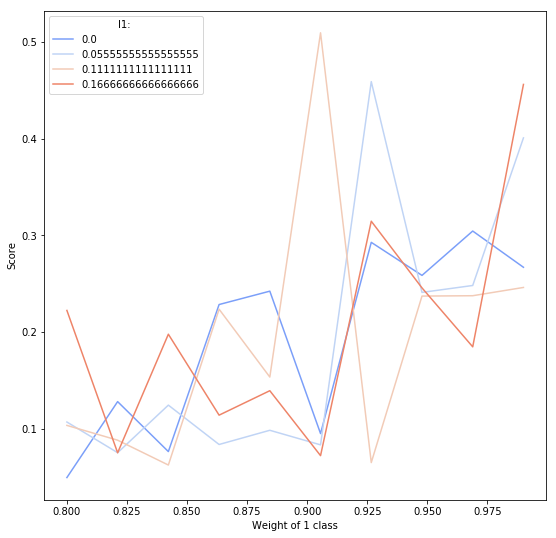

In [45]:
# plot training results

x_ = [i[1] for k, i in enumerate(res['param_class_weight']) if (k % 10) ==0]
l_ = res['param_l1_ratio'][:10]
s_ = res['mean_test_score']

c = sns.color_palette("coolwarm", 4)

fig = plt.figure(figsize=(9,9))

for i in range(4):
    y_ = [j for k, j in enumerate(s_) if (k % 10) == i]
    plt.plot(x_, y_, color=c[i], label=l_[i])
    
plt.xlabel('Weight of 1 class')
plt.ylabel('Score')
plt.legend(title='l1: ');

The model has very low recall and precision so it is not appropriate to identify outliers. I'm going to add new features to dataset.

### Add new features

Add new features of the type: att x/att y and select such that has the largest coefficient of variation.

In [27]:
# new features are relations of old ones
names = list(df_tr.columns.values[1:])
df_new = df_tr.loc[:, ['outlier']]
small_const = 0.1**(10)

for i in df_tr.columns.values[1:]:
    names.remove(i)
    curr_col = (df_tr.loc[:, i] + small_const)
    
    for j in names:
        df_new.loc[:, i + ' '+ j] = curr_col / (df_tr.loc[:, j] + small_const)
        
df_new.drop(columns=['outlier'], inplace=True)

In [28]:
# select from all new variables only such that have large CV (> 0.9)
# so there are 36 new variables
indx = (pd.DataFrame(df_new.std()/abs(df_new.mean())) > 0.9).iloc[:, 0].values
df_new = df_new.loc[:, indx]

For features, such that in boxplot (aftr log transformation)  ouliers are all points except 0, add column that contain their maximum value.

In [29]:
subset1 = [3, 6, 7, 8, 9, 12, 21]
subset1 = ['att' + str(i) for i in subset1]
df_new.loc[:, 'max_subset1'] = df.loc[:, subset1].max(axis=1)

For features, such that in boxplot (after log transformation)  ouliers are all 0 points, add column that contain their minimum value.

In [30]:
subset2 = [4, 10, 13, 14, 22, 23, 26, 27]
subset2 = ['att' + str(i) for i in subset1]
df_new.loc[:, 'min_subset2'] = df.loc[:, subset1].max(axis=1)

In [31]:
df_new.shape

(50000, 38)

In [42]:
# join new features
indx_train = X_train.index.values
indx_test = X_test.index.values
X_train = X_train.join(df_new.loc[indx_train], on='id')
X_test = X_test.join(df_new.loc[indx_test], on='id')

In [43]:
save_dataset(X_train, X_test, y_train, y_test, add='_2')
df_new.to_csv('extra_features.data')

### Train logistic regression with new variables

#### 1. Select features

In [51]:
# firstly build the model to select variables
# so the weight of class 1 is not very small (to prevent the constant model)
# and constant l_1 is not very large to have larger subset of features
# as futher regularisation is still used

class_w = rand.uniform(low=0.1, high=0.3, size=20)
c = np.linspace(0, 0.5, 10) 
classifier = ['log']

params = {'class_weight': [{0: z, 1: 1.0-z} for z in class_w], 
          'l1_ratio': c,
          'loss': classifier},


model, res = find_optimal_SGD(X_train, y_train, params, score=make_scorer(pr_auc), n_it=50)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  6.0min finished


PR AUC: 0.27
Recall score: 0.00
Precision score: 0.50
ROC AUC: 0.50
Avg precision: 0.03


In [52]:
model

SGDClassifier(alpha=0.0001, average=False,
       class_weight={0: 0.2741523736201412, 1: 0.7258476263798588},
       epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.1111111111111111, learning_rate='optimal', loss='log',
       max_iter=100, n_iter=None, n_jobs=1, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [53]:
# look at coefficients
model_coef = pd.DataFrame({'features': X_train.columns.values, 'logit coef': model.coef_[0]}) 
model_coef.sort_values(by='logit coef', ascending=False)

features  logit coef
67  att11 att22    1.116735
87  att23 att25    0.990571
81  att17 att25    0.948469
57   att4 att19    0.857373
64  att10 att16    0.491639
9         att10    0.467284
62   att5 att25    0.403955
55   att2 att22    0.345434
12        att13    0.230781
79  att17 att19    0.220430
43     att17_tr    0.209878
89  att25 att27    0.157816
76  att15 att19    0.157039
84  att19 att25    0.149257
47     att21_tr    0.139739
49     att23_tr    0.099525
37     att11_tr    0.096766
31      att5_tr    0.092844
25        att26    0.068084
36     att10_tr    0.064727
34      att8_tr    0.062840
82  att18 att19    0.060331
46     att20_tr    0.040947
61   att5 att22    0.033640
35      att9_tr    0.033424
32      att6_tr    0.033052
56   att2 att25    0.017738
69  att13 att15    0.017650
13        att14    0.015868
52     att26_tr    0.001236
..          ...         ...
11        att12    0.000000
3          att4    0.000000
29      att3_tr   -0.005047
41     att15_tr   -0.030953
50     att24_tr   -0.059316
86  att22 att27   -0.070578
26        att27   -0.079630
45     att19_tr   -0.079846
48     att22_tr   -0.096438
83  att18 att25   -0.107657
40     att14_tr   -0.172711
39     att13_tr   -0.196040
75  att14 att25   -0.197983
60   att5 att19   -0.226848
88  att24 att25   -0.228446
85  att19 att27   -0.251184
70  att13 att18   -0.384154
59   att4 att25   -0.396004
54   att2 att19   -0.453771
63  att10 att15   -0.493519
77  att15 att25   -0.545758
73  att14 att19   -0.558967
0          att1   -0.585192
80  att17 att22   -0.600757
65  att10 att18   -0.694129
71  att13 att19   -0.882487
68  att11 att25   -0.965497
72  att14 att16   -1.066455
58   att4 att22   -1.126552
27      att1_tr   -2.368300

[92 rows x 2 columns]

In [54]:
# select names of variables with non-zero coefficient
names = model_coef.loc[model_coef['logit coef'] !=0, 'features'].values

#### 2. Build the model with fewer features. Hypertparameter optimization with randomized search.

Recall is 0 inspite of the fact it is in the score functions to optimize. 

In [108]:
class_w = rand.uniform(low=0.01, high=0.3, size=20)
c = np.linspace(0, 0.5, 10) 
classifier = ['log']

params = {'class_weight': [{0: z, 1: 1.0-z} for z in class_w], 
          'l1_ratio': c,
          'loss': classifier},


model, res = find_optimal_SGD(X_train.loc[:, names], y_train, params, 
                              score={'PR': make_scorer(pr_auc), 
                                     'recall': 'recall'}, # use two score functions to optimaze the parameters
                              refit='PR', n_it=50)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.5min finished


PR AUC: 0.52
Recall score: 0.00
Precision score: 1.00
ROC AUC: 0.50


From table with training results it is clear that much better variant is to set l_1 around 0.16 and weight of 0-class around 0.03

In [119]:
pd.DataFrame(res).sort_values(by='mean_test_recall', ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_loss  \
22       1.369406      0.002409         0.007546        0.000054        log   
4        1.357933      0.001381         0.007023        0.000608        log   
32       1.370950      0.000665         0.007261        0.000376        log   
35       1.375992      0.009262         0.007898        0.000452        log   
24       1.363028      0.003439         0.006932        0.000172        log   
8        1.354194      0.001358         0.006842        0.000110        log   
25       1.368957      0.007363         0.006788        0.000070        log   
40       1.402230      0.025565         0.007005        0.000350        log   
37       1.482172      0.040827         0.006807        0.000363        log   
28       1.379647      0.008094         0.006763        0.000179        log   
9        1.355573      0.002556         0.006699        0.000089        log   
46       1.402994      0.037422         0.008557        0.002635        log   
7        1.347536      0.002784         0.006641        0.000198        log   
1        1.346916      0.002028         0.006657        0.000215        log   
33       1.354073      0.003122         0.006553        0.000210        log   
6        1.361599      0.013912         0.006682        0.000099        log   
13       1.359716      0.006751         0.006574        0.000044        log   
10       1.378203      0.051335         0.006603        0.000076        log   
11       1.391728      0.039911         0.006787        0.000271        log   
34       1.358506      0.002869         0.006508        0.000065        log   
14       1.368545      0.008222         0.007053        0.000652        log   
17       1.400496      0.041849         0.007822        0.001729        log   
44       1.345354      0.001834         0.006574        0.000071        log   
30       1.351103      0.004315         0.006909        0.000492        log   
23       1.357115      0.009897         0.006563        0.000054        log   
48       1.383636      0.027394         0.006584        0.000053        log   
43       1.360904      0.012452         0.006527        0.000123        log   
15       1.492173      0.140799         0.006605        0.000104        log   
2        1.349459      0.010369         0.007575        0.001441        log   
19       1.382030      0.012330         0.006643        0.000057        log   
29       1.346488      0.002560         0.006464        0.000087        log   
27       1.349465      0.003764         0.006446        0.000158        log   
20       1.393666      0.028200         0.006556        0.000050        log   
21       1.356597      0.007665         0.006477        0.000114        log   
38       1.412637      0.035437         0.010187        0.004709        log   
39       1.367253      0.015510         0.006440        0.000068        log   
45       1.349272      0.004451         0.006442        0.000075        log   
18       1.377930      0.011917         0.006510        0.000050        log   
3        1.343775      0.003354         0.006534        0.000060        log   
26       1.356397      0.007179         0.006433        0.000075        log   
12       1.372895      0.007834         0.006429        0.000017        log   
16       1.363710      0.009515         0.006405        0.000038        log   
31       1.348952      0.001633         0.006431        0.000028        log   
42       1.378741      0.005800         0.007165        0.001033        log   
47       1.380075      0.024828         0.007165        0.000939        log   
36       1.416892      0.047786         0.006525        0.000018        log   
41       1.406539      0.051380         0.006797        0.000539        log   
5        1.344168      0.003713         0.006488        0.000038        log   
0        1.347374      0.010537         0.006429        0.000136        log   
49       1.367602      0.025170         0.009458      

In [109]:
model

SGDClassifier(alpha=0.0001, average=False,
       class_weight={0: 0.23352685910659823, 1: 0.7664731408934018},
       epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.2777777777777778, learning_rate='optimal', loss='log',
       max_iter=100, n_iter=None, n_jobs=1, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

#### 3.  Build the model with fewer features. Hypertparameter optimization with grid search.

In [149]:
# set small class weight for 0 class
class_w = np.linspace(0.01, 0.09, 10)
c = np.linspace(0.05, 0.2, 10)
classifier = ['log']

params = {'class_weight': [{0: z, 1: 1.0-z} for z in class_w], 
          'l1_ratio': c,
          'loss': classifier},


model, res = find_optimal_SGD(X_train.loc[:, names], y_train, params, 
                              score={'PR': make_scorer(pr_auc), 'recall': 'recall', 'precision': 'precision'}, 
                              refit='PR', random=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  7.2min finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.51


In [150]:
model

SGDClassifier(alpha=0.0001, average=False, class_weight={0: 0.01, 1: 0.99},
       epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.13333333333333336, learning_rate='optimal', loss='log',
       max_iter=100, n_iter=None, n_jobs=1, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [151]:
# plot the results of training
res = pd.DataFrame(res)
x = [i[1] for i in res.loc[res['param_l1_ratio'] == 0.05, 'param_class_weight']]
y1 = res.loc[res['param_l1_ratio'] == 0.05, 'mean_test_PR']
y2 = res.loc[res['param_l1_ratio'] == 0.05, 'mean_test_recall']
y3 = res.loc[res['param_l1_ratio'] == 0.05, 'mean_test_precision']

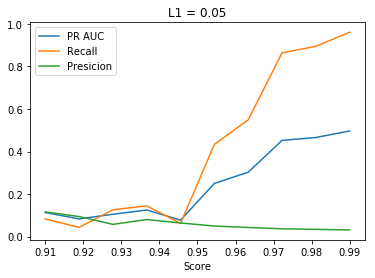

In [152]:
plt.plot(x, y1, label='PR AUC')
plt.plot(x, y2, label='Recall')
plt.plot(x, y3, label='Presicion')
plt.legend()
plt.title('L1 = 0.05')
plt.xlabel('Weight of 1')
plt.xlabel('Score');

Almost all observations labeled as anomaly. 
Just 1% of data is labeled as 0.

In [156]:
(X_train.shape[0] - sum(model.predict(X_train[names])))/X_train.shape[0]

0.01265

#### 4. Ensemble of simple models

As the above attempts were not successful I'm going to build several simple random models and select such ones that have positive recall and roc-auc > 0.5 and to use their ensemble to predict outliers.

In [37]:
import random

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle = True, 
                                                    stratify = y_train, random_state=42)

In [47]:
import pyprind

In [95]:
models = []
names = set(X_train.columns.values)
high = X_train.shape[0] * 0.2
low = X_train.shape[0] * 0.005

for i in range(100):
    print('------------------------------' + str(i) + '------------------------------')
    # select random features
    subsample = random.sample(names, random.randint(5, 10))
    
    class_w = np.linspace(0.01, 0.1, 10)
    c = np.linspace(0, 0.3, 10)
    classifier = ['log']

    params = {'class_weight': [{0: z, 1: 1.0-z} for z in class_w], 
              'l1_ratio': c,
              'loss': classifier},


    gs = find_optimal_SGD(X_train[subsample], y_train, params, 
                                  score={'avg_pr': 'average_precision', 'ROC': 'roc_auc', 
                                         'recall': 'recall'}, 
                                  refit='recall', best_only=False)

    # add only if recall is positive
    if gs.best_score_ > 0:
        m = gs.best_estimator_
        
        # three conditions should be satisfied:
        # add only if roc-auc is > 0.5
        # constant models are bad so I select such that predict at least more than 0.5% of 1
        # but no more than 20%
        if (roc_auc_score(y_train, m.predict_proba(X_train[subsample])[:,1]) > 0.5) & \
            (sum(m.predict(X_train[subsample])) < high) & \
            (sum(m.predict(X_train[subsample])) > low):
            models.append([subsample, m])
    
    

------------------------------0------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.9s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------1------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   17.5s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------2------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.6s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------3------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.1s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------4------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   21.0s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------5------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   21.7s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.51
Avg precision: 0.03
------------------------------6------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   21.3s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------7------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.1s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------8------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   17.7s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------9------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.4s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------10------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   17.2s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------11------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   21.5s finished


PR AUC: 0.07
Recall score: 0.08
Precision score: 0.04
ROC AUC: 0.51
Avg precision: 0.03
------------------------------12------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.6s finished


PR AUC: 0.51
Recall score: 0.99
Precision score: 0.03
ROC AUC: 0.51
Avg precision: 0.03
------------------------------13------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.5s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------14------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   17.2s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------15------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   17.4s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------16------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.9s finished


PR AUC: 0.29
Recall score: 0.53
Precision score: 0.04
ROC AUC: 0.55
Avg precision: 0.03
------------------------------17------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.3s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------18------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.4s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------19------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.8s finished


PR AUC: 0.49
Recall score: 0.95
Precision score: 0.03
ROC AUC: 0.51
Avg precision: 0.03
------------------------------20------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   23.5s finished


PR AUC: 0.20
Recall score: 0.33
Precision score: 0.04
ROC AUC: 0.55
Avg precision: 0.03
------------------------------21------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   21.7s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------22------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.6s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------23------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.6s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------24------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.4s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------25------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.0s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------26------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.3s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------27------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.6s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------28------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.9s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.51
Avg precision: 0.03
------------------------------29------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   21.0s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------30------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.0s finished


PR AUC: 0.47
Recall score: 0.91
Precision score: 0.03
ROC AUC: 0.52
Avg precision: 0.03
------------------------------31------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.7s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------32------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.2s finished


PR AUC: 0.13
Recall score: 0.18
Precision score: 0.05
ROC AUC: 0.54
Avg precision: 0.03
------------------------------33------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   17.1s finished


PR AUC: 0.03
Recall score: 0.01
Precision score: 0.02
ROC AUC: 0.50
Avg precision: 0.03
------------------------------34------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.8s finished


PR AUC: 0.51
Recall score: 0.99
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------35------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.1s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------36------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.3s finished


PR AUC: 0.08
Recall score: 0.09
Precision score: 0.04
ROC AUC: 0.51
Avg precision: 0.03
------------------------------37------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.3s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------38------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.3s finished


PR AUC: 0.39
Recall score: 0.74
Precision score: 0.04
ROC AUC: 0.57
Avg precision: 0.04
------------------------------39------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.9s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------40------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.7s finished


PR AUC: 0.33
Recall score: 0.61
Precision score: 0.03
ROC AUC: 0.54
Avg precision: 0.03
------------------------------41------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.9s finished


PR AUC: 0.50
Recall score: 0.98
Precision score: 0.03
ROC AUC: 0.52
Avg precision: 0.03
------------------------------42------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.4s finished


PR AUC: 0.48
Recall score: 0.92
Precision score: 0.03
ROC AUC: 0.51
Avg precision: 0.03
------------------------------43------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.7s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------44------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.4s finished


PR AUC: 0.08
Recall score: 0.09
Precision score: 0.04
ROC AUC: 0.51
Avg precision: 0.03
------------------------------45------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.2s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------46------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   17.5s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------47------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.0s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------48------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.0s finished


PR AUC: 0.43
Recall score: 0.83
Precision score: 0.03
ROC AUC: 0.51
Avg precision: 0.03
------------------------------49------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.7s finished


PR AUC: 0.37
Recall score: 0.70
Precision score: 0.03
ROC AUC: 0.53
Avg precision: 0.03
------------------------------50------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.9s finished


PR AUC: 0.49
Recall score: 0.95
Precision score: 0.03
ROC AUC: 0.51
Avg precision: 0.03
------------------------------51------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.3s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------52------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   17.9s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------53------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   23.8s finished


PR AUC: 0.47
Recall score: 0.90
Precision score: 0.03
ROC AUC: 0.52
Avg precision: 0.03
------------------------------54------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.1s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------55------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   22.8s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------56------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.9s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------57------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   17.8s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------58------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   23.2s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------59------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   24.3s finished


PR AUC: 0.52
Recall score: 0.00
Precision score: 0.00
ROC AUC: 0.50
Avg precision: 0.03
------------------------------60------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/ksu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   22.3s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------61------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   21.0s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------62------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   21.7s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------63------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   21.6s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------64------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   22.2s finished


PR AUC: 0.50
Recall score: 0.97
Precision score: 0.03
ROC AUC: 0.52
Avg precision: 0.03
------------------------------65------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.5s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------66------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.3s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------67------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   23.2s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------68------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   25.0s finished


PR AUC: 0.47
Recall score: 0.91
Precision score: 0.03
ROC AUC: 0.54
Avg precision: 0.03
------------------------------69------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.1s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------70------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   22.1s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------71------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.7s finished


PR AUC: 0.49
Recall score: 0.96
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------72------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.5s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------73------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.8s finished


PR AUC: 0.46
Recall score: 0.88
Precision score: 0.03
ROC AUC: 0.55
Avg precision: 0.03
------------------------------74------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.0s finished


PR AUC: 0.29
Recall score: 0.53
Precision score: 0.03
ROC AUC: 0.53
Avg precision: 0.03
------------------------------75------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.6s finished


PR AUC: 0.08
Recall score: 0.06
Precision score: 0.06
ROC AUC: 0.52
Avg precision: 0.03
------------------------------76------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.1s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------77------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.9s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------78------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.0s finished


PR AUC: 0.52
Recall score: 0.00
Precision score: 0.00
ROC AUC: 0.50
Avg precision: 0.03
------------------------------79------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/ksu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   17.4s finished


PR AUC: 0.49
Recall score: 0.94
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------80------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.8s finished


PR AUC: 0.51
Recall score: 0.99
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------81------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   22.5s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------82------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.2s finished


PR AUC: 0.02
Recall score: 0.00
Precision score: 0.00
ROC AUC: 0.50
Avg precision: 0.03
------------------------------83------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.6s finished


PR AUC: 0.23
Recall score: 0.41
Precision score: 0.04
ROC AUC: 0.53
Avg precision: 0.03
------------------------------84------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.8s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------85------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   22.4s finished


PR AUC: 0.08
Recall score: 0.01
Precision score: 0.11
ROC AUC: 0.50
Avg precision: 0.03
------------------------------86------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   17.7s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------87------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   21.0s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------88------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.2s finished


PR AUC: 0.49
Recall score: 0.95
Precision score: 0.03
ROC AUC: 0.52
Avg precision: 0.03
------------------------------89------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.9s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------90------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.9s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------91------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.1s finished


PR AUC: 0.35
Recall score: 0.65
Precision score: 0.03
ROC AUC: 0.53
Avg precision: 0.03
------------------------------92------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.2s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------93------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.6s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------94------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   23.5s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------95------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.0s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------96------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   17.2s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------97------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   22.0s finished


PR AUC: 0.51
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------98------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.7s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03
------------------------------99------------------------------
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.8s finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03


In [96]:
pred_proba = pd.DataFrame()

for i, (n, m) in enumerate(models):
    pred_proba.loc[:, i] = m.predict_proba(X_train[n])[:, 1]
        
pred_proba.set_index(X_train.index.values, inplace=True)

In [97]:
pred_proba.loc[:, 'avg'] = pred_proba.mean(axis=1)
pred_proba.loc[:, 'max'] = pred_proba.max(axis=1)
pred_proba.loc[:, 'min'] = pred_proba.min(axis=1)

In [106]:
pred_proba.join(y_train).iloc[100:200]

0         1         2         3         4         5       avg  \
39950  0.456838  0.218261  0.249250  0.390122  0.349411  0.267387  0.321878   
27397  0.453087  0.359754  0.250329  0.412508  0.353490  0.356604  0.364295   
19625  0.455432  0.275450  0.189632  0.336818  0.377613  0.416233  0.341863   
35004  0.481191  0.223007  0.286945  0.400326  0.457082  0.391174  0.373288   
28638  0.487247  0.217588  0.266753  0.378321  0.305651  0.249059  0.317437   
23883  0.475489  0.695118  0.197327  0.401866  0.363307  0.386286  0.419899   
43797  0.427113  0.525639  0.249911  0.410711  0.421140  0.397702  0.405370   
36926  0.447833  0.278476  0.245373  0.386144  0.368527  0.376669  0.350504   
42102  0.456678  0.528904  0.239505  0.431683  0.371876  0.404044  0.405448   
22830  0.426548  0.316341  0.245337  0.416968  0.371461  0.356948  0.355601   
39629  0.470269  0.248915  0.194570  0.382074  0.304390  0.377816  0.329672   
40573  0.428010  0.311433  0.240199  0.414405  0.366741  0.327105  0.347982   
3575   0.439241  0.223790  0.242811  0.411349  0.374015  0.342288  0.338916   
28944  0.458827  0.281456  0.237153  0.382986  0.273128  0.313949  0.324583   
4675   0.493443  0.358284  0.277732  0.410194  0.442333  0.362995  0.390830   
2692   0.490602  0.319131  0.281230  0.431212  0.389662  0.375831  0.381278   
39278  0.484289  0.231527  0.201304  0.225539  0.235491  0.196638  0.262465   
18593  0.474073  0.428885  0.429021  0.437271  0.387763  0.512747  0.444960   
19275  0.504218  0.528139  0.539165  0.435369  0.398263  0.543621  0.491463   
24552  0.432676  0.318661  0.252222  0.620797  0.687506  0.392212  0.450679   
28500  0.492070  0.130793  0.206268  0.341820  0.306210  0.225262  0.283737   
26385  0.504799  0.309800  0.215370  0.161386  0.179030  0.318623  0.281501   
25704  0.446580  0.318412  0.242665  0.435582  0.356217  0.343233  0.357115   
1077   0.452657  0.317238  0.267652  0.440611  0.387882  0.378030  0.374011   
45057  0.476128  0.238232  0.266313  0.394007  0.344844  0.326700  0.341037   
18367  0.477503  0.382314  0.429771  0.606938  0.689692  0.481999  0.511369   
40153  0.448994  0.324858  0.243027  0.437887  0.381128  0.395619  0.371919   
36143  0.442043  0.425583  0.185681  0.303994  0.305114  0.393263  0.342613   
25821  0.443991  0.330720  0.248246  0.425338  0.377718  0.369723  0.365956   
11970  0.457433  0.455571  0.190001  0.364398  0.340407  0.430208  0.373003   
...         ...       ...       ...       ...       ...       ...       ...   
42445  0.462968  0.285423  0.192166  0.376694  0.297573  0.385005  0.333305   
43524  0.506691  0.243426  0.302544  0.562609  0.640143  0.296367  0.425297   
31848  0.446672  0.404175  0.186985  0.332566  0.306941  0.345870  0.337202   
9420   0.431359  0.403795  0.233170  0.396690  0.411939  0.385426  0.377063   
42200  0.426369  0.470534  0.181757  0.418466  0.374993  0.386559  0.376446   
11051  0.482776  0.548291  0.276611  0.440685  0.402761  0.415534  0.427776   
13739  0.451471  0.329572  0.239731  0.367003  0.413507  0.332297  0.355597   
24515  0.425623  0.341696  0.241871  0.420991  0.387670  0.333630  0.358580   
19786  0.456542  0.461817  0.259611  0.420357  0.363034  0.373347  0.389118   
10915  0.447585  0.496857  0.255282  0.450799  0.408391  0.406678  0.410932   
20409  0.442532  0.278856  0.185811  0.371627  0.328315  0.335251  0.323732   
43786  0.425979  0.537861  0.249409  0.414558  0.419544  0.349439  0.399465   
21037  0.455492  0.481652  0.254684  0.452365  0.391263  0.367487  0.400490   
6048   0.462347  0.260127  0.191617  0.356709  0.341098  0.359992  0.328648   
46532  0.443791  0.331804  0.248483  0.438924  0.378203  0.399154  0.373393   
31748  0.465199  0.285719  0.267641  0.425141  0.358772  0.270082  0.345426   
2407   0.450405  0.274735  0.265719  0.437407  0.385165  0.385078  0.366418   
44558  0.448154  0.413520  0.187336  0.383770  0.363677  0.435455  0.371985   
20942  0.437868  0.324763  0.246988  0.447590  0.389529  0.36244

In [100]:
# set small class weight for 0 class
class_w = np.linspace(0.01, 0.3, 10)
c = np.linspace(0.05, 0.5, 10)
classifier = ['log']

params = {'class_weight': [{0: z, 1: 1.0-z} for z in class_w], 
          'l1_ratio': c,
          'loss': classifier},


model, res = find_optimal_SGD(pred_proba, y_train, params, 
                              score={'PR': make_scorer(pr_auc), 'ROC': 'roc_auc', 
                                         'recall': 'recall'}, 
                              refit='PR', random=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  3.4min finished


PR AUC: 0.52
Recall score: 1.00
Precision score: 0.03
ROC AUC: 0.50
Avg precision: 0.03


In [102]:
pd.DataFrame(res).sort_values(by='mean_test_PR', ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.651064      0.046339         0.011679        0.002821   
63       0.622731      0.028471         0.009150        0.000492   
73       0.620622      0.009603         0.009582        0.000166   
72       0.614863      0.008086         0.013545        0.005459   
71       0.624589      0.009765         0.009506        0.000123   
70       0.669068      0.046612         0.009585        0.000115   
69       0.652048      0.046097         0.009998        0.000681   
68       0.612165      0.016708         0.009869        0.000389   
67       0.620909      0.040557         0.009540        0.000071   
66       0.589384      0.001316         0.009583        0.000087   
65       0.717099      0.069910         0.010197        0.000601   
64       0.859148      0.046208         0.010321        0.000461   
62       0.629349      0.011147         0.009808        0.000590   
1        0.659996      0.040193         0.010346        0.001022   
61       0.645564      0.023082         0.013654        0.007249   
60       0.735172      0.083869         0.012133        0.003481   
59       0.599343      0.002124         0.009025        0.000827   
58       0.606929      0.004617         0.009437        0.000085   
57       0.636237      0.008212         0.014815        0.006045   
56       0.656077      0.019570         0.011308        0.001636   
55       0.690886      0.059839         0.013583        0.001632   
54       0.646749      0.043169         0.009455        0.000086   
53       0.667705      0.075185         0.010948        0.002083   
52       0.628043      0.020792         0.009676        0.000090   
74       0.619580      0.001366         0.009780        0.000263   
75       0.606052      0.008323         0.009700        0.000129   
76       0.608004      0.012069         0.009870        0.000432   
77       0.636266      0.017448         0.009234        0.000870   
98       0.634512      0.027980         0.010653        0.000864   
97       0.708436      0.090733         0.010395        0.001200   
..            ...           ...              ...             ...   
33       0.622402      0.005862         0.009516        0.000133   
36       0.626689      0.014345         0.012211        0.002241   
34       0.694676      0.043228         0.011150        0.001293   
32       0.616570      0.012517         0.009475        0.000138   
37       0.651384      0.009127         0.010467        0.000681   
30       0.620646      0.016125         0.009609        0.000105   
35       0.703142      0.109283         0.010074        0.000928   
38       0.737548      0.076079         0.011156        0.001588   
39       0.915693      0.074138         0.023667        0.004845   
31       0.609796      0.003450         0.009795        0.000501   
15       0.712848      0.048871         0.014553        0.003408   
10       0.633839      0.008802         0.010099        0.000190   
11       0.617733      0.002477         0.011025        0.001287   
19       0.688278      0.081438         0.013080        0.004268   
16       0.679708      0.063540         0.010648        0.000971   
14       0.678705      0.016518         0.014721        0.003366   
12       0.623078      0.004211         0.009955        0.000197   
13       0.641273      0.010294         0.010218        0.000321   
17       0.631324      0.023480         0.009804        0.000089   
18       0.621449      0.005357         0.010031        0.000254   
24       0.683071      0.110465         0.009623        0.000217   
20       0.695996      0.070227         0.009774        0.000037   
22       0.705342      0.036747         0.010554        0.000567   
21       0.665884      0.067058         0.015932        0.008775   
26       0.641815      0.023421         0.009689        0.000038   
28       0.644243      0.029818         0.009597        0.000166   
27       0.677234      0.053797         0.012137        0.00

In [103]:
model

SGDClassifier(alpha=0.0001, average=False, class_weight={0: 0.01, 1: 0.99},
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.05,
       learning_rate='optimal', loss='log', max_iter=100, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [ ]:
def mahalanobis_distance(df, center=None):
    if center is None:
        center = df.mean()
        
    cov = df.cov()
    inv_cov = np.linalg.inv(cov)
    
    diff = df - center
    d = diff.transpose.as_matrix() * inv_cov * diff.as_matrix()

In [ ]:
# algorithm from 
# https://link.springer.com/article/10.1007/s10994-015-5521-0

def loda(df):
    n = df.shape[1]
    m = int(n**(0.5))
    n_range = set(range(n))
    non_zero_index = random.sample(n_range, m)
    w = np.zeros(n)
    
    for i in non_zero_index:
        w[i] = random.normal(size=1)
    